In [ ]:
# 1. Setup: Install packages (if needed) and check CUDA
!pip install torchvision --quiet

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader

In [ ]:
# 2. Mount Google Drive (for dataset/geasy saving)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 3. Paths and transforms (update to your path if needed)
DATA_DIR = "/content/drive/MyDrive/preprocessed_sipakmed_dataset"
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
# 4. Load the complete dataset from one folder
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print("Classes:", dataset.classes)

Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']


In [ ]:
# 5. Split dataset into train, val, test (e.g. 70%, 15%, 15%)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 2846, Val: 610, Test: 611


In [ ]:
# 6. DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
from torchvision.models import efficientnet_v2_s
model = efficientnet_v2_s(weights="IMAGENET1K_V1")
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)  # correct index
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 137MB/s]


In [ ]:
# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer (important — do this BEFORE training loop)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)


In [ ]:
# 8. Training Loop (as before, with validation after each epoch)
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Validation Accuracy: {100*correct/total:.2f}%")


Epoch 1/20 - Loss: 0.1294
Validation Accuracy: 95.25%
Epoch 2/20 - Loss: 0.2959
Validation Accuracy: 93.44%
Epoch 3/20 - Loss: 0.0106
Validation Accuracy: 96.72%
Epoch 4/20 - Loss: 0.0545
Validation Accuracy: 96.89%
Epoch 5/20 - Loss: 0.0163
Validation Accuracy: 96.07%
Epoch 6/20 - Loss: 0.0332
Validation Accuracy: 96.39%
Epoch 7/20 - Loss: 0.0011
Validation Accuracy: 95.57%
Epoch 8/20 - Loss: 0.0587
Validation Accuracy: 96.23%
Epoch 9/20 - Loss: 0.0568
Validation Accuracy: 95.74%
Epoch 10/20 - Loss: 0.0113
Validation Accuracy: 97.38%
Epoch 11/20 - Loss: 0.0222
Validation Accuracy: 94.75%
Epoch 12/20 - Loss: 0.0354
Validation Accuracy: 95.08%
Epoch 13/20 - Loss: 0.0272
Validation Accuracy: 96.23%
Epoch 14/20 - Loss: 0.0008
Validation Accuracy: 94.59%
Epoch 15/20 - Loss: 0.0220
Validation Accuracy: 97.38%
Epoch 16/20 - Loss: 0.0115
Validation Accuracy: 96.39%
Epoch 17/20 - Loss: 0.0287
Validation Accuracy: 96.07%
Epoch 18/20 - Loss: 0.0240
Validation Accuracy: 96.89%
Epoch 19/20 - Loss:

In [ ]:
# 9. Save the model weights to Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/efficientnetv2s_cervical_cancer.pth")
print("Model saved!")

Model saved!


In [ ]:
model.eval()  # Set model to evaluation mode

correct, total = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:  # test_loader must be defined as for validation
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Forward pass (logits)
        _, preds = outputs.max(1)  # Get predicted class labels

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print test accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 96.40%


In [ ]:
class_names = test_loader.dataset.dataset.classes  # If you used random_split from ImageFolder
print("Predictions:", [class_names[i] for i in all_preds])


Predictions: ['im_Superficial-Intermediate', 'im_Dyskeratotic', 'im_Koilocytotic', 'im_Parabasal', 'im_Superficial-Intermediate', 'im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Dyskeratotic', 'im_Parabasal', 'im_Superficial-Intermediate', 'im_Metaplastic', 'im_Koilocytotic', 'im_Parabasal', 'im_Dyskeratotic', 'im_Koilocytotic', 'im_Superficial-Intermediate', 'im_Parabasal', 'im_Dyskeratotic', 'im_Metaplastic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Parabasal', 'im_Dyskeratotic', 'im_Koilocytotic', 'im_Superficial-Intermediate', 'im_Superficial-Intermediate', 'im_Dyskeratotic', 'im_Dyskeratotic', 'im_Superficial-Intermediate', 'im_Metaplastic', 'im_Dyskeratotic', 'im_Dyskeratotic', 'im_Metaplastic', 'im_Superficial-Intermediate', 'im_Superficial-Intermediate', 'im_Parabasal', 'im_Koilocytotic', 'im_Koilocytotic', 'im_Dyskeratotic', 'im_Koilocytotic', 'im_Parabasal', 'im_Parabasal', 'im_Koilocytotic', 'im_Metaplastic', 'im_Dyskeratotic', 'im

In [ ]:
from PIL import Image
from torchvision import transforms
import torch

# 1. Upload image from local system (runs in Colab)
from google.colab import files
uploaded = files.upload()

# Assuming only one file uploaded, get its filename
image_path = next(iter(uploaded.keys()))

# 2. Define the same preprocessing as training
preprocess = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 3. Load and preprocess the image
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dim and send to device

# 4. Load your saved model (if not loaded yet)
# model.load_state_dict(torch.load("/content/drive/MyDrive/efficientnetv2s_cervical_cancer.pth"))
# model = model.to(device)
model.eval()

# 5. Predict
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = output.max(1)
    predicted_class_idx = predicted.item()

# 6. Map predicted index to class name
class_names = dataset.classes  # Make sure train_dataset is loaded and in scope
predicted_class = class_names[predicted_class_idx]

print(f"Predicted Class: {predicted_class}")


Saving koilocytotic_1.jpeg to koilocytotic_1.jpeg
Predicted Class: im_Dyskeratotic


In [ ]:
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


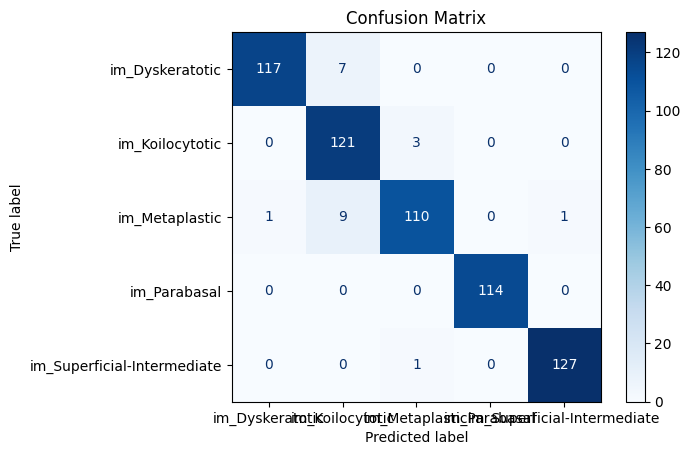

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# **Way - 1 to increase efficiency: Train Longer with Cyclic Learning Rates**


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torchvision.models import efficientnet_v2_s

In [ ]:
# 3. Dataset paths & preprocessing transforms
DATA_DIR = "/content/drive/MyDrive/preprocessed_sipakmed_dataset"
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [ ]:
# 4. Load dataset and class info
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(dataset.classes)
print("Classes:", dataset.classes)

# 5. Split dataset to train, val, test (70%, 15%, 15%)
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']
Train: 2846, Val: 610, Test: 611


In [ ]:
# 6. Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

# 7. Model: load EfficientNetV2-S with pretrained weights & adapt classifier
model = efficientnet_v2_s(weights="IMAGENET1K_V1")
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)  # adjust output layer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
# 8. Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# 9. Training loop with validation after each epoch
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/20 - Loss: 0.4861
Validation Accuracy: 93.11%
Epoch 2/20 - Loss: 0.1541
Validation Accuracy: 96.23%
Epoch 3/20 - Loss: 0.0772
Validation Accuracy: 96.23%
Epoch 4/20 - Loss: 0.0760
Validation Accuracy: 95.90%
Epoch 5/20 - Loss: 0.0521
Validation Accuracy: 94.59%
Epoch 6/20 - Loss: 0.0417
Validation Accuracy: 95.25%
Epoch 7/20 - Loss: 0.0342
Validation Accuracy: 94.59%
Epoch 8/20 - Loss: 0.0350
Validation Accuracy: 96.23%
Epoch 9/20 - Loss: 0.0301
Validation Accuracy: 93.93%
Epoch 10/20 - Loss: 0.0321
Validation Accuracy: 95.41%
Epoch 11/20 - Loss: 0.0253
Validation Accuracy: 95.74%
Epoch 12/20 - Loss: 0.0149
Validation Accuracy: 94.10%
Epoch 13/20 - Loss: 0.0273
Validation Accuracy: 94.75%
Epoch 14/20 - Loss: 0.0330
Validation Accuracy: 95.90%
Epoch 15/20 - Loss: 0.0117
Validation Accuracy: 96.39%
Epoch 16/20 - Loss: 0.0098
Validation Accuracy: 95.57%
Epoch 17/20 - Loss: 0.0271
Validation Accuracy: 96.72%
Epoch 18/20 - Loss: 0.0117
Validation Accuracy: 96.72%
Epoch 19/20 - Loss:

In [ ]:
# 10. Save trained model weights to Google Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/efficientnetv2s_cervical_cancer_way1.pth")
print("Model saved!")

In [ ]:
# 11. Test the model on test set
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")